# Modeling Stock Market Sentiment with LSTMs

The idea of this notebook is to build LSTMs with basic tensorflow modules. I basically followed this [tutorial](https://github.com/GarrettHoffman/lstm-oreilly/blob/master/Stock%20Market%20Sentiment%20with%20LSTMs%20and%20TensorFlow.ipynb).

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter

## Read Data

In [2]:
data = pd.read_csv('data/StockTwits_SPY_Sentiment_2017.gz',
                  encoding='utf-8',
                  compression='gzip',
                  index_col=0)

In [3]:
data.head()

,message,sentiment
0,$SPY crazy day so far!,bearish
1,$SPY Will make a new ATH this week. Watch it!,bullish
2,$SPY $DJIA white elephant in room is $AAPL. Up...,bearish
3,$SPY blocks above. We break above them We shou...,bullish
4,"$SPY Nothing happening in the market today, gu...",bearish


In [4]:
messages = data['message'].values
labels = data['sentiment'].values

## Preprocess data

In [5]:
import re

In [6]:
import string

In [7]:
def preprocess_ST_message(text):
    '''Preprocess raw message for analysis'''
    # define regular expression patterns
    REGEX_PRICE_SIGN = re.compile(r'\$(?!\d*\.?\d+%)\d*\.?\d+|(?!\d*\.?\d+%)\d*\.?\d+\$')
    REGEX_PRICE_NOSIGN = re.compile(r'(?!\d*\.?\d+%)(?!\d*\.?\d+k)\d*\.?\d+')
    REGEX_TICKER = re.compile('\$[a-zA-Z]+')
    REGEX_USER = re.compile('\@\w+')
    REGEX_LINK = re.compile('https?:\/\/[^\s]+')
    REGEX_HTML_ENTITY = re.compile('\&\w+')
    REGEX_NON_ACSII = re.compile('[^\x00-\x7f]')
    REGEX_PUNCTUATION = re.compile(
        '[%s]' % re.escape(string.punctuation.replace('<', '')).replace('>', ''))
    REGEX_NUMBER = re.compile(r'[-+]?[0-9]+')
    
    # convert all letters to lower cases
    text = text.lower()
    
    # replace entities with a unique token
    text = re.sub(REGEX_TICKER, ' <TICKER> ', text)
    text = re.sub(REGEX_USER, ' <USER> ', text)
    text = re.sub(REGEX_LINK, ' <LINK> ', text)
    text = re.sub(REGEX_PRICE_SIGN, ' <PRICE> ', text)
    text = re.sub(REGEX_PRICE_NOSIGN, ' <NUMBER> ', text)
    text = re.sub(REGEX_NUMBER, ' <NUMBER> ', text)
    
    # remove extraneous text data
    text = re.sub(REGEX_HTML_ENTITY, '', text)
    text = re.sub(REGEX_NON_ACSII, '', text)
    text = re.sub(REGEX_PUNCTUATION, '', text)
    
    words = ' '.join(token.replace('<', '').replace('>', '')
            if token not in ['<TICKER>', '<USER>', '<LINK>', '<PRICE>', '<NUMBER>']
            else token
            for token in text.split())
    return words

In [8]:
print('Original message:', messages[0])
print('Preprocessed message:', preprocess_ST_message(messages[0]))

Original message: $SPY crazy day so far!
Preprocessed message: <TICKER> crazy day so far


In [9]:
messages = np.array([preprocess_ST_message(message) for message in messages])

In [10]:
def build_dicts(words, n_words=10000):
    '''Create look up dictionaries, add <PAD> as the padding word
    and <UNK> for words unknown
    '''
    counts = [['<PAD>', -1], ['<UNK>', -1]]
    counts.extend(Counter(words).most_common(n_words-2))
    word2ind = {item[0]: i for i, item in enumerate(counts)}
    ind2word = {i: j for i, j in zip(word2ind.items(), word2ind.keys())}
    return word2ind, ind2word

In [11]:
word2ind, ind2word = build_dicts(' '.join(messages).split())

### Check Message Lengths

In [12]:
message_lens = Counter(len(item) for item in messages)

In [13]:
print('Maximum length:', max(message_lens))
print('Minimum length:', min(message_lens))
print('Number of zero-length message:', message_lens[0])

Maximum length: 244
Minimum length: 0
Number of zero-length message: 1


Plot histogram

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

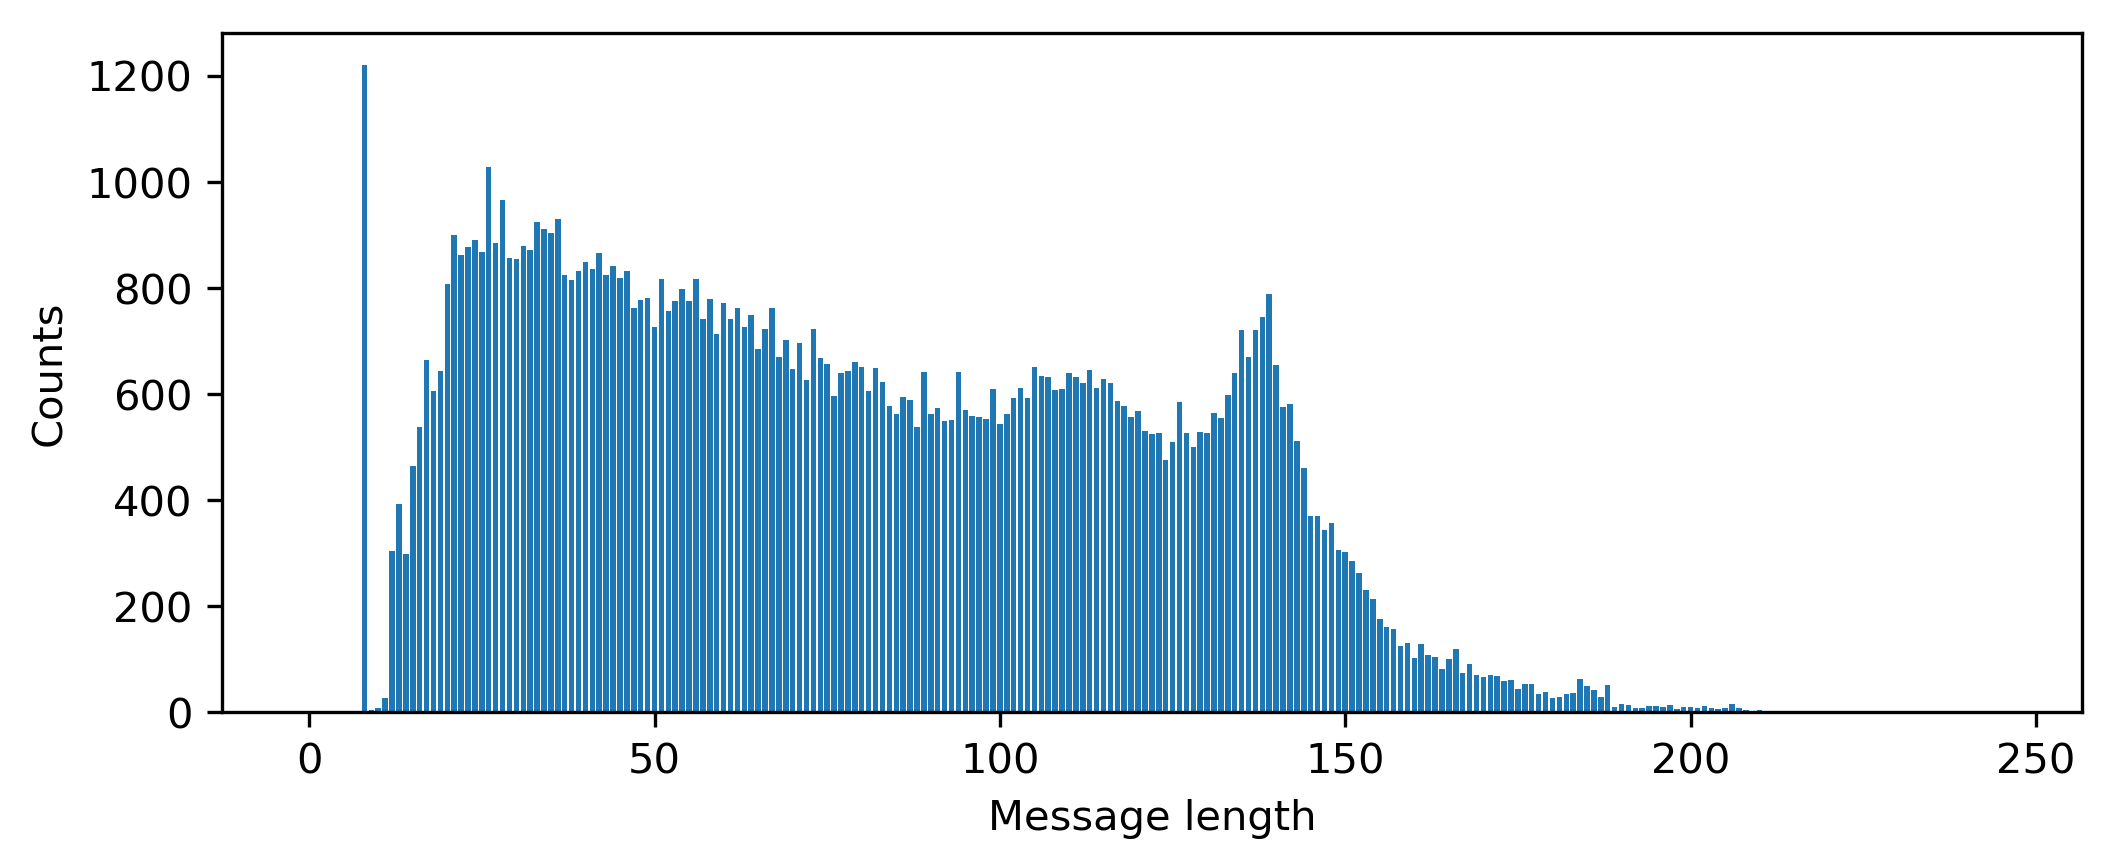

In [15]:
fig = plt.figure(figsize=(8,3), dpi=300)
plt.bar(message_lens.keys(), message_lens.values())
plt.xlabel('Message length')
plt.ylabel('Counts');

### Drop zero length messages

In [16]:
def drop_empty_messages(messages, labels):
    indexes = [len(item) for item in messages if len(item)]
    return messages[indexes], labels[indexes]

In [17]:
messages, labels = drop_empty_messages(messages, labels)

### Encode messages and labels

Convert the messages to int

In [18]:
labels

array(['bullish', 'bearish', 'bullish', ..., 'bearish', 'bearish',
       'bearish'], dtype=object)

In [19]:
def message_encoder(messages, word2ind):
    encoded = []
    for message in messages:
        encoded.append([word2ind.get(item, word2ind['<UNK>']) 
                        for item in message.split()])
    return np.array(encoded)

def label_encoder(labels):
    encoded = np.array([1 if label=='bullish' else 0 for label in labels])
    encoded = encoded.reshape(-1, 1)
    return np.array(encoded)

In [20]:
messages = message_encoder(messages, word2ind)
labels = label_encoder(labels)

### Pad the messages to have same length

In [21]:
def pad_messages(messages, length):
    '''Pad the messages so that all messages have same length,
    if the message is longer than the max length, cut the tail.'''
    padded = np.zeros((len(messages), length), dtype=np.int32)
    for i, message in enumerate(messages):
        padded[i, -len(message):] = message[:length]
    return padded

In [22]:
messages = pad_messages(messages, length=max(message_lens))
messages.shape

(96966, 244)

### Train, test, validation split

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
def train_val_test_split(data, labels, train_frac=0.8):
    train_x, val_x, train_y, val_y = train_test_split(data, labels, test_size=1-train_frac)
    val_x, test_x, val_y, test_y = train_test_split(val_x, val_y, test_size=0.5)
    return train_x, val_x, test_x, train_y, val_y, test_y

In [25]:
train_x, val_x, test_x, train_y, val_y, test_y = train_val_test_split(messages, labels)

In [26]:
print(len(train_x), len(val_x), len(test_x))

77572 9697 9697


## Build model

In [84]:
class LSTM_model(object):
    def __init__(self, word_length, vocab_size, embed_size, lstm_sizes, keep_prob=1):
        print('Building LSTMs')
        self.word_length = word_length
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_sizes = lstm_sizes
        self._keep_prob = keep_prob
        
        self.build_LSTMs()
        
    def build_LSTMs(self):
        # build inputs
        tf.reset_default_graph()
        self.inputs = tf.placeholder(tf.int32, [None, self.word_length], name='inputs')
        self.labels = tf.placeholder(tf.float32, [None, 1], name='labels')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')

        # embedding layer
        self.embeddings = tf.Variable(tf.random_uniform([self.vocab_size, 
                                                         self.embed_size], 
                                                        -1, 1))
        self.embed = tf.nn.embedding_lookup(self.embeddings, self.inputs)

        # LSTM layer
        lstms = [tf.nn.rnn_cell.LSTMCell(size) for size in self.lstm_sizes]
        drops = [tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=self.keep_prob)
                    for lstm in lstms]
        self.cell = tf.contrib.rnn.MultiRNNCell(drops)

        # initial state
        batch_size = tf.shape(self.inputs)[0]
        self.initial_state = self.cell.zero_state(batch_size, tf.float32)

        # lstm output
        lstm_outputs, self.final_state = tf.nn.dynamic_rnn(self.cell, self.embed, 
                                            initial_state=self.initial_state)

        # loss function, only use the fully connected layer on the last sequence of lstms
        logits = tf.contrib.layers.fully_connected(lstm_outputs[:, -1],
                                                        num_outputs=1,
                                                        activation_fn=None)

        self.predictions = tf.round(tf.sigmoid(logits))
        correct = tf.equal(self.predictions, self.labels)
        self.accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=self.labels))
        
    def fetch_batch(self, X, y=None, epoch=1, batch_size=32, train_mode=True):
        if train_mode:
            dataset = tf.data.Dataset.from_tensor_slices((X, y))
            dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).repeat(epoch)
            X_batch, y_batch = dataset.make_one_shot_iterator().get_next()
            return X_batch, y_batch
        else:
            dataset = tf.data.Dataset.from_tensor_slices(X)
            dataset = dataset.batch(batch_size)
            X_batch= dataset.make_one_shot_iterator().get_next()
            return X_batch

    def train(self, data, labels, learning_rate, validate_data=None, validate_labels=None,
              batch_size=32, epoch=1, max_iter=100):
        X_batch, y_batch = self.fetch_batch(data, labels, batch_size=batch_size, epoch=epoch)
        if (validate_data is not None) and (validate_labels is not None):
            valid = True
            X_val_batch, y_val_batch = self.fetch_batch(validate_data, 
                                                       validate_labels,
                                                       epoch=-1)
        else:
            valid = False
        train = tf.train.AdadeltaOptimizer(learning_rate).minimize(self.loss)
        n_iter = 0
        epoch = 0
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            try:
                while n_iter < max_iter:
                    input_batch, label_batch = sess.run([X_batch, y_batch])
                    feed_dict = {self.inputs: input_batch, 
                                 self.labels: label_batch, 
                                 self.keep_prob: self._keep_prob}
                    if n_iter > 0:
                        feed_dict[self.initial_state] = state
                    state, _ = sess.run([self.final_state, train], feed_dict)
                    if valid and n_iter%10 == 0:
                        X_val, y_val = sess.run([X_val_batch, y_val_batch])
                        feed_dict = {self.inputs: X_val, 
                                     self.labels: y_val, 
                                     self.keep_prob: 1}
                        acc = sess.run(self.accuracy, feed_dict)
                        print('Iteration', n_iter, acc)
                    n_iter += 1
            except tf.errors.OutOfRangeError:
                print('--- All epoches completed ---')
            print('--- Training ends ---')
            saver.save(sess, 'checkpoints/sentiment.ckpt')
    
    def predict(self, data, path='checkpoints', batch_size=32):
        saver = tf.train.Saver()
        predicts = np.ndarray((len(data), 1))
        current_idx = 0
        X_batch = self.fetch_batch(data, batch_size=batch_size, train_mode=False)
        with tf.Session() as sess:
            saver.restore(sess, tf.train.latest_checkpoint(path))
            try:
                while True:
                    input_batch = sess.run(X_batch)
                    feed_dict = {self.inputs: input_batch,
                                self.keep_prob: 1}
                    # change initial_state won't work for the last batch
                    # if the last batch size is not the same as previous mini-batch
#                     if current_idx > 0:
#                         feed_dict[self.initial_state] = state
                    state, y_ = sess.run([self.final_state, self.predictions], feed_dict)
                    predicts[current_idx:current_idx+batch_size, :] = y_
                    current_idx += batch_size
            except tf.errors.OutOfRangeError:
                print('--- All epoches completed ---')
            print('--- Prediction ends ---')
        return predicts

In [85]:
temp = LSTM_model(train_x.shape[1], len(word2ind), 128, [128, 64], keep_prob=0.5)

Building LSTMs


In [78]:
temp.train(train_x, train_y, 0.1, val_x, val_y)

Iteration 0 0.34375
Iteration 10 0.46875
Iteration 20 0.59375
Iteration 30 0.53125
Iteration 40 0.5625
Iteration 50 0.5
Iteration 60 0.4375
Iteration 70 0.4375
Iteration 80 0.5625
Iteration 90 0.6875
--- Training ends ---


In [86]:
temp.predict(test_x[:100])

INFO:tensorflow:Restoring parameters from checkpoints/sentiment.ckpt
--- All epoches completed ---
--- Prediction ends ---


array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
      